In this notebook I demonstrate the usage of decision trees, random forests and xgboost. There are few concepts to be cited before:

- Entropy: it measures of impurity of a node in a tree

$$S(p_1) = -p_1 \log_2{p_1} - (1 - p_1)\log_2{(1 - p_1)}$$

where $p_1$ is the fraction of true positives in the node.

- Information gain: it measures the purity was accomplished after splitting a node

$$IG = S(p_1^\text{root}) - w^\text{left} S(p_1^\text{left}) - w^\text{right} S(p_1^\text{right})$$
where $w$ refers to fraction of number of sample in a node with respect to whole dataset

- One hot encode: for multiple output features, e.g. a feature color with outputs red, blue or green, we transform each output in a binary one, i.e. red and non-red as 0 or 1 and so on

- Sampling with replacement: in order to use tree ensembles, we sample a subset of the dataset and replace it into the dataset, in other words, we include the sampled data in a new raffle

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import sqlite3
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

STATE = 60

To understand these concepts we will use the Credit Score dataset, available in [kaggle](https://www.kaggle.com/datasets/parisrohan/credit-score-classification), in order to classify clients.

In [3]:
connection = sqlite3.connect('data/Credit.db')
cursor = connection.cursor()

Cleaning and exploring the data:

In [4]:
score = cursor.execute("SELECT DISTINCT Credit_Score FROM credit").fetchall()
print(score)

[('Good',), ('Standard',), ('Poor',)]


In [5]:
n_customers = cursor.execute("SELECT DISTINCT Customer_ID FROM credit WHERE Age > 0 AND Annual_Income != 'NaN' AND Payment_Behaviour != '!@9#%8'").fetchall()
print(len(n_customers))

12500


In [6]:
p_behaviour = cursor.execute("SELECT DISTINCT Payment_Behaviour AS pb FROM credit WHERE pb != '!@9#%8'").fetchall()
print(p_behaviour)

[('High_spent_Small_value_payments',), ('Low_spent_Large_value_payments',), ('Low_spent_Medium_value_payments',), ('Low_spent_Small_value_payments',), ('High_spent_Medium_value_payments',), ('High_spent_Large_value_payments',)]


In [4]:
data_sql = cursor.execute("""
SELECT CAST(Age AS DECIMAL), Num_Credit_Card, Num_Bank_Accounts, Interest_Rate, Num_of_Loan, Num_of_Delayed_Payment, Delay_from_due_date, Num_Credit_Inquiries, Annual_Income, Outstanding_Debt, Credit_Utilization_Ratio, Changed_Credit_Limit, Amount_invested_monthly, Payment_Behaviour, Credit_Score
FROM (SELECT ID, Customer_ID, Age, Annual_Income, Num_Credit_Card, Num_Bank_Accounts, Interest_Rate, Num_of_Loan, Num_of_Delayed_Payment, Delay_from_due_date, Num_Credit_Inquiries, Outstanding_Debt, Credit_Utilization_Ratio, Changed_Credit_Limit, Amount_invested_monthly, Payment_Behaviour, Credit_Score,
    ROW_NUMBER() OVER (PARTITION BY Customer_ID ORDER BY ID) AS RowNumber
    FROM credit) AS a
WHERE a.RowNumber = 1
AND Payment_Behaviour != '!@9#%8'
AND CAST(Age AS DECIMAL) < 101
AND CAST(Age AS DECIMAL) > 0
AND Num_Credit_Inquiries != 'NA'
AND Num_of_Loan >= 0
""").fetchall()
data_sql = np.array(data_sql)

In [5]:
cols = ['Age', 'Num_Credit_Card', 'Num_Bank_Accounts', 'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Annual_Income', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Payment_Behaviour', 'Credit_Score']
data_pd = pd.DataFrame(data_sql, columns=cols)
data_pd.head()

,Age,Num_Credit_Card,Num_Bank_Accounts,Interest_Rate,Num_of_Loan,Num_of_Delayed_Payment,Delay_from_due_date,Num_Credit_Inquiries,Annual_Income,Outstanding_Debt,Credit_Utilization_Ratio,Changed_Credit_Limit,Amount_invested_monthly,Payment_Behaviour,Credit_Score
0,17,5,6,27,2,25,62,10.0,30625.94,1562.91,26.612093,1.63,244.75028300769162,Low_spent_Large_value_payments,Standard
1,25,5,6,17,4,1749,8,2.0,52312.68,202.68,23.679534,9.73,261.2109793689318,Low_spent_Medium_value_payments,Standard
2,18,4,1,1,0,7,14,1.0,113781.38999999998,1030.2,37.99876,11.34,397.24184577026637,Low_spent_Medium_value_payments,Poor
3,43,3,3,17,3,12,27,7.0,58918.47,473.14,27.513599,14.42,74.56738634988751,High_spent_Large_value_payments,Standard
4,43,3,3,6,3,9,12,3.0,98620.98,1233.51,41.920614,1.33,258.6945882722829,High_spent_Medium_value_payments,Standard


In [6]:
data_pd_ = data_pd[cols[:-2]].replace('_','', regex=True)
data_pd_1 = data_pd_[cols[:-2]].apply(pd.to_numeric)
data_pd_2 = data_pd[cols[-2:]]
data_pd_temp = data_pd_1.join(data_pd_2)
data_pd_clean = data_pd_temp.dropna()

In [7]:
X_data_pd = data_pd_clean[cols[:-1]]
y_data_pd = data_pd_clean[cols[-1]]

In [8]:
X_data_pd = X_data_pd.astype({'Num_Credit_Inquiries':np.int16})

Making one hot encoding for *Payment_Behaviour*:

In [9]:
X_data_pd = pd.get_dummies(X_data_pd, 'Payment_Behaviour', 'Payment_Behaviour')
X_data_pd.head(5)

,Age,Num_Credit_Card,Num_Bank_Accounts,Interest_Rate,Num_of_Loan,Num_of_Delayed_Payment,Delay_from_due_date,Num_Credit_Inquiries,Annual_Income,Outstanding_Debt,Credit_Utilization_Ratio,Changed_Credit_Limit,Amount_invested_monthly,Payment_BehaviourPayment_BehaviourHigh_spent_Large_value_payments,Payment_BehaviourPayment_BehaviourHigh_spent_Medium_value_payments,Payment_BehaviourPayment_BehaviourHigh_spent_Small_value_payments,Payment_BehaviourPayment_BehaviourLow_spent_Large_value_payments,Payment_BehaviourPayment_BehaviourLow_spent_Medium_value_payments,Payment_BehaviourPayment_BehaviourLow_spent_Small_value_payments
0,17,5,6,27,2,25.0,62,10,30625.94,1562.91,26.612093,1.63,244.750283,0,0,0,1,0,0
1,25,5,6,17,4,1749.0,8,2,52312.68,202.68,23.679534,9.73,261.210979,0,0,0,0,1,0
2,18,4,1,1,0,7.0,14,1,113781.39,1030.20,37.998760,11.34,397.241846,0,0,0,0,1,0
3,43,3,3,17,3,12.0,27,7,58918.47,473.14,27.513599,14.42,74.567386,1,0,0,0,0,0
4,43,3,3,6,3,9.0,12,3,98620.98,1233.51,41.920614,1.33,258.694588,0,1,0,0,0,0


In [10]:
X_train, X_cv, y_train, y_cv = train_test_split(X_data_pd, y_data_pd, train_size=0.8, random_state=STATE)

In [57]:
X_train.head(3)

,Age,Num_Credit_Card,Num_Bank_Accounts,Interest_Rate,Num_of_Loan,Num_of_Delayed_Payment,Delay_from_due_date,Num_Credit_Inquiries,Annual_Income,Outstanding_Debt,Credit_Utilization_Ratio,Changed_Credit_Limit,Amount_invested_monthly,Payment_BehaviourPayment_BehaviourHigh_spent_Large_value_payments,Payment_BehaviourPayment_BehaviourHigh_spent_Medium_value_payments,Payment_BehaviourPayment_BehaviourHigh_spent_Small_value_payments,Payment_BehaviourPayment_BehaviourLow_spent_Large_value_payments,Payment_BehaviourPayment_BehaviourLow_spent_Medium_value_payments,Payment_BehaviourPayment_BehaviourLow_spent_Small_value_payments
7223,29,3,4,5,1,6.0,18,0,163032.60,18.93,31.310474,15.30,1199.870211,0,0,0,1,0,0
5232,23,2,3,7,2,9.0,9,4,16653.50,574.43,39.689331,11.50,55.738249,0,0,0,0,0,1
3483,37,5,1,2,0,11.0,12,3,44968.15,871.85,31.613032,8.22,240.022760,0,0,1,0,0,0


In [93]:
y_train.head(3)

7223        Good
5232        Good
3483    Standard
Name: Credit_Score, dtype: object

In [44]:
X_train['Age'].unique()

array([29, 23, 37, 52, 40, 42, 16, 25, 46, 14, 41, 18, 47, 26, 36, 28, 30,
       39, 34, 49, 44, 19, 51, 32, 55, 45, 24, 38, 31, 21, 50, 33, 48, 27,
       22, 15, 54, 17, 43, 53, 35, 20, 95], dtype=int64)

In [55]:
print(len(X_train), len(y_train))

7400 7400


#### Decision tree

Testing a simple decision tree:

In [56]:
model = DecisionTreeClassifier(random_state=STATE).fit(X_train, y_train)

In [57]:
pred_train = model.predict(X_train)
pred_cv = model.predict(X_cv)

In [58]:
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_cv = accuracy_score(pred_cv, y_cv)

print(f'The accuracy over train sample is {accuracy_train*100:.2f}% and over cross-validation is {accuracy_cv*100:.2f}%.')

The accuracy over train sample is 100.00% and over cross-validation is 67.08%.


In [66]:
min_samples_array = np.geomspace(1,1500,20, dtype=int)
max_depth_array = np.geomspace(2,90,15, dtype=int)

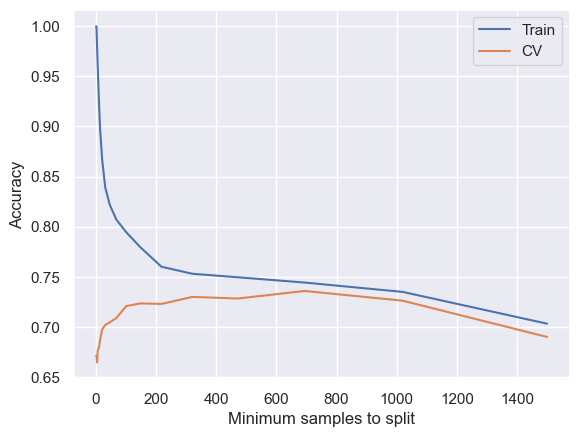

In [60]:
accuracy_train_array = np.zeros(len(min_samples_array))
accuracy_cv_array = np.zeros(len(min_samples_array))

i = 0
for min_samples in min_samples_array:
    model = DecisionTreeClassifier(min_samples_split=min_samples, random_state=STATE).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_cv = model.predict(X_cv)
    accuracy_train = accuracy_score(pred_train, y_train)
    accuracy_cv = accuracy_score(pred_cv, y_cv)
    accuracy_train_array[i] = accuracy_train
    accuracy_cv_array[i] = accuracy_cv
    i += 1

sb.set()
plt.plot(min_samples_array, accuracy_train_array, label='Train')
plt.plot(min_samples_array, accuracy_cv_array, label='CV')
plt.legend()
plt.xlabel('Minimum samples to split')
plt.ylabel('Accuracy')
plt.show()

1000 for minimum samples to split in a node is a candidate to avoid overfitting and to get a reasonable performance.

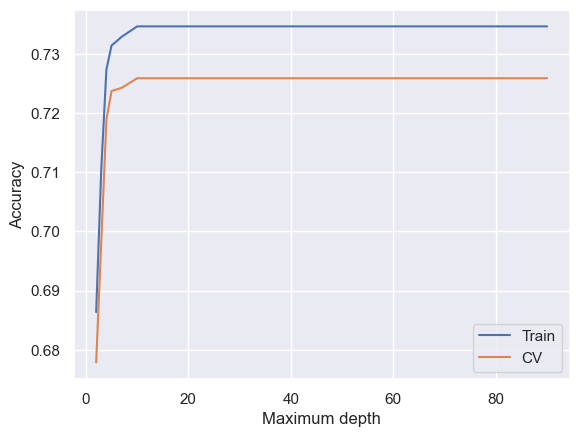

In [61]:
accuracy_train_array = np.zeros(len(max_depth_array))
accuracy_cv_array = np.zeros(len(max_depth_array))

i = 0
for max_depth in max_depth_array:
    model = DecisionTreeClassifier(min_samples_split=1000, max_depth=max_depth, random_state=STATE).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_cv = model.predict(X_cv)
    accuracy_train = accuracy_score(pred_train, y_train)
    accuracy_cv = accuracy_score(pred_cv, y_cv)
    accuracy_train_array[i] = accuracy_train
    accuracy_cv_array[i] = accuracy_cv
    i += 1

sb.set()
plt.plot(max_depth_array, accuracy_train_array, label='Train')
plt.plot(max_depth_array, accuracy_cv_array, label='CV')
plt.legend()
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.show()

In [62]:
model = DecisionTreeClassifier(min_samples_split=1000, max_depth=max_depth, random_state=STATE).fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_cv = model.predict(X_cv)

accuracy_train = accuracy_score(pred_train, y_train)
accuracy_cv = accuracy_score(pred_cv, y_cv)

print(accuracy_train, accuracy_cv)

0.7347297297297297 0.725945945945946


#### Random Forest

In [70]:
n_estimatiors_array = np.geomspace(2,1500,30, dtype=int)
max_depth_array = np.geomspace(2,40,15, dtype=int)

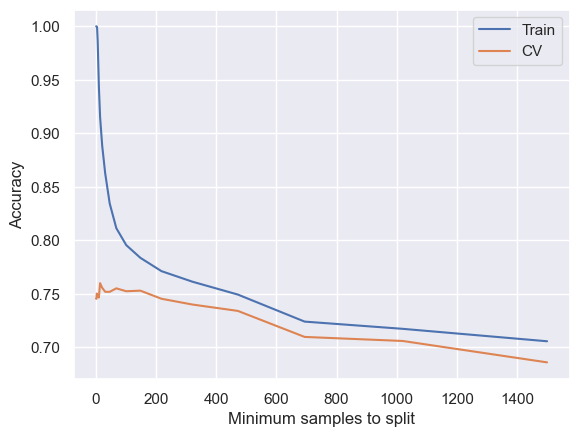

In [64]:
accuracy_train_array = np.zeros(len(min_samples_array))
accuracy_cv_array = np.zeros(len(min_samples_array))

i = 0
for min_samples in min_samples_array:
    model = RandomForestClassifier(min_samples_split=min_samples, random_state=STATE).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_cv = model.predict(X_cv)
    accuracy_train = accuracy_score(pred_train, y_train)
    accuracy_cv = accuracy_score(pred_cv, y_cv)
    accuracy_train_array[i] = accuracy_train
    accuracy_cv_array[i] = accuracy_cv
    i += 1

sb.set()
plt.plot(min_samples_array, accuracy_train_array, label='Train')
plt.plot(min_samples_array, accuracy_cv_array, label='CV')
plt.legend()
plt.xlabel('Minimum samples to split')
plt.ylabel('Accuracy')
plt.show()

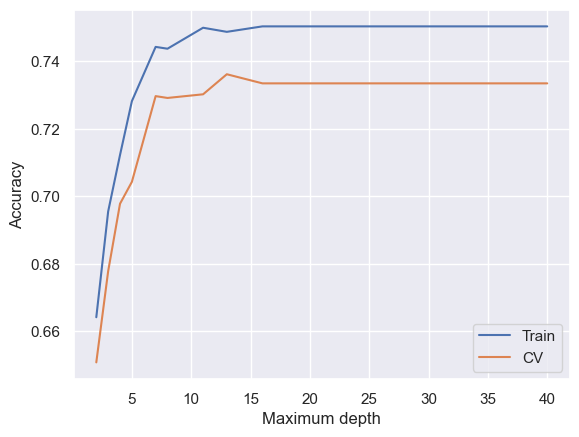

In [68]:
accuracy_train_array = np.zeros(len(max_depth_array))
accuracy_cv_array = np.zeros(len(max_depth_array))

i = 0
for max_depth in max_depth_array:
    model = RandomForestClassifier(min_samples_split=480, max_depth=max_depth, random_state=STATE).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_cv = model.predict(X_cv)
    accuracy_train = accuracy_score(pred_train, y_train)
    accuracy_cv = accuracy_score(pred_cv, y_cv)
    accuracy_train_array[i] = accuracy_train
    accuracy_cv_array[i] = accuracy_cv
    i += 1

sb.set()
plt.plot(max_depth_array, accuracy_train_array, label='Train')
plt.plot(max_depth_array, accuracy_cv_array, label='CV')
plt.legend()
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.show()

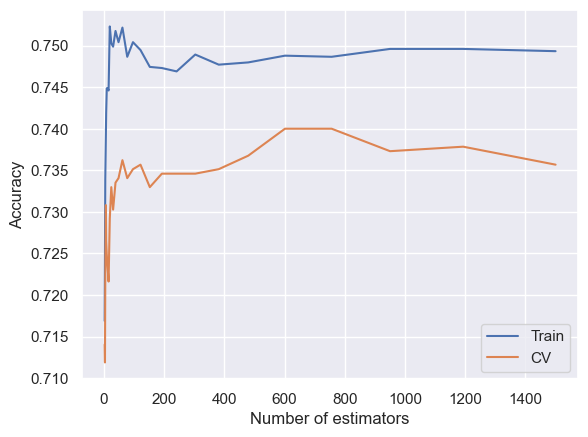

In [71]:
accuracy_train_array = np.zeros(len(n_estimatiors_array))
accuracy_cv_array = np.zeros(len(n_estimatiors_array))

i = 0
for n_trees in n_estimatiors_array:
    model = RandomForestClassifier(min_samples_split=480, max_depth=14, n_estimators=n_trees, random_state=STATE).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_cv = model.predict(X_cv)
    accuracy_train = accuracy_score(pred_train, y_train)
    accuracy_cv = accuracy_score(pred_cv, y_cv)
    accuracy_train_array[i] = accuracy_train
    accuracy_cv_array[i] = accuracy_cv
    i += 1

sb.set()
plt.plot(n_estimatiors_array, accuracy_train_array, label='Train')
plt.plot(n_estimatiors_array, accuracy_cv_array, label='CV')
plt.legend()
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.show()

In [72]:
model = RandomForestClassifier(n_estimators=700, max_depth=14, min_samples_split=480).fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_cv = model.predict(X_cv)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_cv = accuracy_score(pred_cv, y_cv)

print(accuracy_train, accuracy_cv)

0.7513513513513513 0.7367567567567568


Testing GridSearchCV:

In [ ]:
model = RandomForestClassifier()

n_estimatiors_array = np.geomspace(2,500,5, dtype=int)
min_samples_array = np.geomspace(1,1500,5, dtype=int)
max_depth_array = np.geomspace(2,90,5, dtype=int)

parameters = {'n_estimators':n_estimatiors_array,
              'max_depth':max_depth_array,
              'min_samples_split':min_samples_array}

grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=10, verbose=3)

grid_fit = grid.fit(X_train, y_train)

In [27]:
grid.best_estimator_

RandomForestClassifier(max_depth=90, min_samples_split=38, n_estimators=125)

In [26]:
pred_train = grid_fit.predict(X_train)
pred_cv = grid_fit.predict(X_cv)

acc_train = accuracy_score(y_train, pred_train)
acc_cv = accuracy_score(y_cv, pred_cv)

print(f'Accuracy:\nTrain:{acc_train*100:.2f}%\nCV:{acc_cv*100:.2f}%')

Accuracy:
Train:82.07%
CV:73.69%


In [29]:
import joblib

joblib.dump(grid, 'models/credit_score/GridSearchCV_for_credit_score.pkl')

['models/credit_score/GridSearchCV_for_credit_score.pkl']

#### XGBoost

In [128]:
X_train_xg, X_eval, y_train_xg, y_eval = train_test_split(X_train, y_train, train_size=0.8, random_state=STATE)

y_train_xg = y_train_xg.replace('Poor',0)
y_train_xg = y_train_xg.replace('Standard',1)
y_train_xg = y_train_xg.replace('Good',2)

y_eval = y_eval.replace('Poor',0)
y_eval = y_eval.replace('Standard',1)
y_eval = y_eval.replace('Good',2)

y_cv_xg = y_cv.replace('Poor',0)
y_cv_xg = y_cv_xg.replace('Standard',1)
y_cv_xg = y_cv_xg.replace('Good',2)

eval = [(X_eval, y_eval)]

In [129]:
xgboost_model = XGBClassifier(n_estimators=500, learning_rate=0.1, random_state=STATE, early_stopping_rounds=10)

In [130]:
xgboost_model.fit(X_train_xg, y_train_xg, eval_set=eval)

[0]	validation_0-mlogloss:1.02706
[1]	validation_0-mlogloss:0.96705
[2]	validation_0-mlogloss:0.91556
[3]	validation_0-mlogloss:0.87073
[4]	validation_0-mlogloss:0.83220
[5]	validation_0-mlogloss:0.79921
[6]	validation_0-mlogloss:0.77000
[7]	validation_0-mlogloss:0.74473
[8]	validation_0-mlogloss:0.72213
[9]	validation_0-mlogloss:0.70223
[10]	validation_0-mlogloss:0.68423
[11]	validation_0-mlogloss:0.66849
[12]	validation_0-mlogloss:0.65424
[13]	validation_0-mlogloss:0.64164
[14]	validation_0-mlogloss:0.63004
[15]	validation_0-mlogloss:0.61971
[16]	validation_0-mlogloss:0.61096
[17]	validation_0-mlogloss:0.60295
[18]	validation_0-mlogloss:0.59595
[19]	validation_0-mlogloss:0.58975
[20]	validation_0-mlogloss:0.58430
[21]	validation_0-mlogloss:0.57884
[22]	validation_0-mlogloss:0.57471
[23]	validation_0-mlogloss:0.57075
[24]	validation_0-mlogloss:0.56658
[25]	validation_0-mlogloss:0.56326
[26]	validation_0-mlogloss:0.56001
[27]	validation_0-mlogloss:0.55728
[28]	validation_0-mlogloss:0.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [131]:
bas = xgboost_model.base_score
bi = xgboost_model.best_iteration
bnl = xgboost_model.best_ntree_limit
bes = xgboost_model.best_score

print(bas,bi,bnl,bes)

None 68 69 0.5323652603937238


In [132]:
pred_train_xg = xgboost_model.predict(X_train_xg)
pred_eval = xgboost_model.predict(X_eval)
pred_cv = xgboost_model.predict(X_cv)

acc_train = accuracy_score(y_train_xg, pred_train_xg)
acc_eval = accuracy_score(y_eval, pred_eval)
acc_cv = accuracy_score(y_cv_xg, pred_cv)

print(f'The accuracy obtained in train and cross validation:\n Train: {acc_train}\n Eval: {acc_eval}\n CV: {acc_cv}')

The accuracy obtained in train and cross validation:
 Train: 0.8628378378378379
 Eval: 0.7587837837837837
 CV: 0.7475675675675676


Comparing to neural networks:

In [83]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

In [84]:
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy()
X_cv_np = X_cv.to_numpy(dtype=np.float32)
y_cv_np = y_cv.to_numpy()

y_train_np[y_train_np == 'Good'] = 2
y_train_np[y_train_np == 'Standard'] = 1
y_train_np[y_train_np == 'Poor'] = 0
y_train_np = y_train_np.astype('int8')

y_cv_np[y_cv_np == 'Good'] = 2
y_cv_np[y_cv_np == 'Standard'] = 1
y_cv_np[y_cv_np == 'Poor'] = 0
y_cv_np = y_cv_np.astype('int8')

In [118]:
def create_model(X_, y_, reg_value, n_units):
    shape_init = tf.keras.Input(shape=(len(X_[0]),))
    units_list = []
    m,n = X_.shape

    model = Sequential([shape_init,
                        Dense(units=n_units, activation='relu', kernel_regularizer=L2(reg_value)),
                        Dense(units=3, activation='linear', kernel_regularizer=L2(reg_value))],
                    name='Using_NN_to_classify%i_units'%n_units
                    )
    # model.summary()
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.01))
    model.fit(X_, y_, epochs=20)
    
    return model

def misclassification(X_, y_, prediction):
    j = 0
    m,n = X_.shape
    for i in range(m):
        ip = np.where(prediction[i] == max(prediction[i]))
        if ip[0][0] != y_[i]:
            j += 1
    J = j/m
    return J

def cost_final(X_, y_, X_cv_, y_cv_, n_units, reg_value):
    model = create_model(X_, y_, reg_value, n_units)
    prediction = model.predict(X_)
    prediction_cv = model.predict(X_cv_)

    J_train = misclassification(X_, y_, prediction)
    J_cv = misclassification(X_cv_, y_cv_, prediction_cv)
    
    return J_train, J_cv, model

def evaluate_units(X_, y_, X_cv_, y_cv_):
    n_units_list = [int(j) for j in range(30,300,30)]
    J_train_array = np.zeros(len(n_units_list))
    J_cv_array = np.zeros(len(n_units_list))
    reg_value = 0.01

    for i in range(len(n_units_list)):
        n_units = n_units_list[i]
        print(n_units, ' units')
        J_train, J_cv, model = cost_final(X_, y_, X_cv_, y_cv_, n_units, reg_value)

        J_train_array[i] = J_train
        J_cv_array[i] = J_cv
        
    return J_train_array, J_cv_array, n_units_list

J_train_array, J_cv_array, n_units_list = evaluate_units(X_train_np, y_train_np, X_cv_np, y_cv_np)

30  units
Epoch 1/20
232/232 [==============================] - 1s 1ms/step - loss: 10231.4258
Epoch 2/20
232/232 [==============================] - 0s 2ms/step - loss: 8764.7920
Epoch 3/20
232/232 [==============================] - 0s 1ms/step - loss: 4361.5537
Epoch 4/20
232/232 [==============================] - 0s 1ms/step - loss: 3082.7351
Epoch 5/20
232/232 [==============================] - 0s 1ms/step - loss: 1795.1573
Epoch 6/20
232/232 [==============================] - 0s 1ms/step - loss: 379.1870
Epoch 7/20
232/232 [==============================] - 0s 1ms/step - loss: 148.9622
Epoch 8/20
232/232 [==============================] - 0s 2ms/step - loss: 2.0241
Epoch 9/20
232/232 [==============================] - 0s 2ms/step - loss: 1.9192
Epoch 10/20
232/232 [==============================] - 0s 1ms/step - loss: 1.8535
Epoch 11/20
232/232 [==============================] - 0s 1ms/step - loss: 1.7934
Epoch 12/20
232/232 [==============================] - 0s 2ms/step - loss: 1.

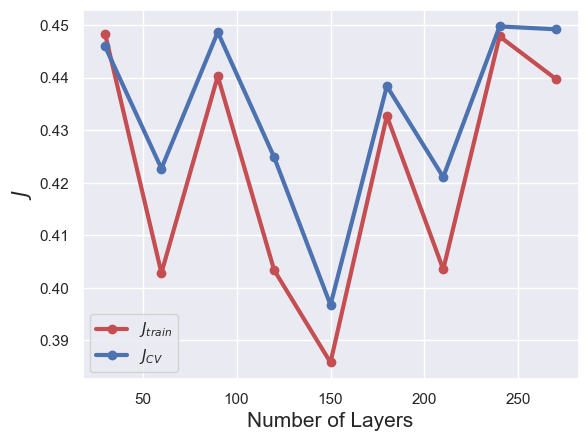

In [119]:
plt.figure(dpi=100)
sb.set()
plt.plot(n_units_list, J_train_array, 'ro-', lw=3, label=r'$J_{train}$')
plt.plot(n_units_list, J_cv_array, 'bo-', lw=3, label=r'$J_{CV}$')
plt.xlabel(r'Number of Layers', fontsize=15)
plt.ylabel(r'$J$', fontsize=15)
plt.legend()
plt.show()

In [145]:
m,n = X_train.shape

print(f'{n} features')

shape_init = tf.keras.Input(shape=(n,))

model = Sequential([shape_init,
                   Dense(units=200, activation='relu', kernel_regularizer=L2(0.01)),
                   Dense(units=150, activation='relu', kernel_regularizer=L2(0.01)),
                   Dense(units=150, activation='relu', kernel_regularizer=L2(0.01)),
                   Dense(units=15, activation='relu', kernel_regularizer=L2(0.01)),
                   Dense(units=10, activation='relu', kernel_regularizer=L2(0.01)),
                   Dense(units=3, activation='linear', kernel_regularizer=L2(0.01))],
                   name='Using_NN_to_classify')

19 features


In [146]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.001))

In [147]:
model.fit(X_train_np, y_train_np, epochs=150)

Epoch 1/150
232/232 [==============================] - 1s 3ms/step - loss: 75.5926
Epoch 2/150
232/232 [==============================] - 1s 2ms/step - loss: 2.5468
Epoch 3/150
232/232 [==============================] - 1s 2ms/step - loss: 2.3885
Epoch 4/150
232/232 [==============================] - 1s 3ms/step - loss: 2.2709
Epoch 5/150
232/232 [==============================] - 1s 4ms/step - loss: 2.2088
Epoch 6/150
232/232 [==============================] - 1s 3ms/step - loss: 2.1621
Epoch 7/150
232/232 [==============================] - 1s 3ms/step - loss: 2.1255
Epoch 8/150
232/232 [==============================] - 1s 3ms/step - loss: 2.0958
Epoch 9/150
232/232 [==============================] - 1s 2ms/step - loss: 2.0709
Epoch 10/150
232/232 [==============================] - 1s 3ms/step - loss: 2.0497
Epoch 11/150
232/232 [==============================] - 1s 2ms/step - loss: 2.0312
Epoch 12/150
232/232 [==============================] - 1s 3ms/step - loss: 2.0145
Epoch 13/150

In [150]:
p = model.predict(X_train_np)
ip_list = []
print(p)

for i in range(len(p)):
    ip = np.where(p[i] == max(p[i]))
    ip_list.append(ip[0])

pred_NN = np.array(ip_list)

232/232 [==============================] - 0s 2ms/step
[[-0.07169543  0.57026416 -0.7017999 ]
 [-0.07169543  0.57026416 -0.7017999 ]
 [-0.07169543  0.57026416 -0.7017999 ]
 ...
 [-0.07169543  0.57026416 -0.7017999 ]
 [-0.07169543  0.57026416 -0.7017999 ]
 [-0.07169543  0.57026416 -0.7017999 ]]


In [ ]:
pred_NN[:100]

In [151]:
acc_train = accuracy_score(y_train_np, pred_NN)
print(acc_train)

0.5514864864864865
